In [81]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import matplotlib.pyplot as plt
import warnings
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [82]:
df = pd.read_csv("../datasets/merged/master.csv", index_col=0, parse_dates=True)

print(df.shape)
df.head()

(3919, 11)


,btc_close,active_addresses,dxy_close,eth_close,fear_greed,gold_close,interest_rate,sp500_close,trend,btc_log_return,btc_rsi
2014-09-17,457.334015,143062.0,84.699997,320.884003,30.0,1234.400024,0.09,2001.569946,22.0,NaN,NaN
2014-09-18,424.440002,143062.0,84.320000,320.884003,30.0,1225.699951,0.09,2011.359985,22.0,-0.074643,NaN
2014-09-19,394.795990,143062.0,84.800003,320.884003,30.0,1215.300049,0.09,2010.400024,22.0,-0.072402,NaN
2014-09-20,408.903992,148220.5,84.756668,320.884003,30.0,1215.800049,0.09,2005.030029,22.0,0.035111,NaN
2014-09-21,398.821014,153379.0,84.713333,320.884003,30.0,1216.300049,0.09,1999.660034,22.0,-0.024968,NaN


El modelo ARIMA requiere que no haya valores faltantes

In [83]:
# Eliminar filas con NaN en columnas críticas
serie = df[['btc_log_return']].dropna()
serie.index.freq = 'D'

# Verificar el resultado
print(f"Filas después de eliminar NaNs: {serie.shape[0]}")
serie.head()


Filas después de eliminar NaNs: 3918


,btc_log_return
2014-09-18,-0.074643
2014-09-19,-0.072402
2014-09-20,0.035111
2014-09-21,-0.024968
2014-09-22,0.008317


Realizaremos el test de ADF (Augmented Dickey-Fuller) para entender si la serie temporal de los retornos es estacionaria

In [84]:
# Aplicar el test ADF
resultado = adfuller(serie)

# Mostrar resultados
print("===== Test de Estacionariedad ADF =====")
print(f"ADF Statistic: {resultado[0]}")
print(f"p-value: {resultado[1]}")

print("Valores críticos:")
for clave, valor in resultado[4].items():
    print(f"  Nivel {clave}: {valor}")


===== Test de Estacionariedad ADF =====
ADF Statistic: -19.009660663120847
p-value: 0.0
Valores críticos:
  Nivel 1%: -3.4320244115897567
  Nivel 5%: -2.862279863367539
  Nivel 10%: -2.5671638379687782


Podemos ver que el p-valor es cero, menor a 0.05 y por lo tanto es estacionaria.

También podemos utilizar el estadístico ADF y decir que al ser mucho menor al nivel más crítico de los valores críticos la serie es estacionaria  

Gracias a esto podremos darle el valor 0 al parámetro d

En vez de usar ARIMA y buscar manualmente los parámetros p y q usaremos AUTO ARIMA que puede buscar los óptimos automáticamente.

In [85]:
warnings.filterwarnings("ignore", category=FutureWarning)

# Ejecutar búsqueda automática
modelo_auto = auto_arima(
    serie,
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=0,  # ya sabemos que es estacionaria
    seasonal=False,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

# Resumen del mejor modelo encontrado
# print(modelo_auto.summary())

# Graficar residuos del modelo para validación visual
# modelo_auto.plot_diagnostics(figsize=(12, 8))
# plt.show()


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-14907.566, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-14907.398, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-14907.347, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-14905.655, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-14911.374, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-14911.476, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-14909.952, Time=0.83 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-14909.685, Time=0.47 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-14911.428, Time=0.31 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-14907.969, Time=0.50 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 2.768 seconds


In [86]:
serie = serie['btc_log_return']
train_size = int(len(serie) * 0.7)
train, test = serie[:train_size], serie[train_size:]

In [87]:

from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

history = list(train)
predictions = []

for actual in test:
    model = ARIMA(history, order=(1, 0, 0)).fit()
    forecast = model.forecast()[0]
    predictions.append(forecast)
    history.append(actual)  # agregamos el valor real para actualizar


📊 MAE:  0.018795
📊 RMSE: 0.027450


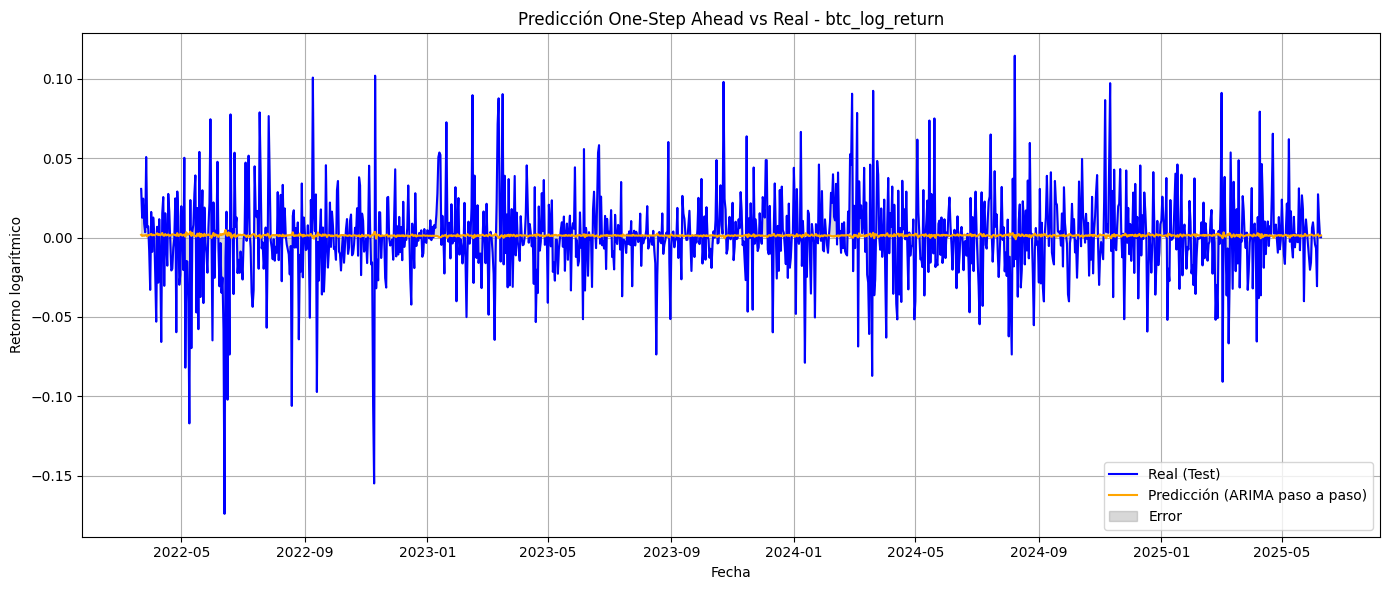

In [88]:
mae = mean_absolute_error(test, predictions)
rmse = np.sqrt(mean_squared_error(test, predictions))

print(f"📊 MAE:  {mae:.6f}")
print(f"📊 RMSE: {rmse:.6f}")

# 4. Graficar predicción vs real
plt.figure(figsize=(14, 6))
plt.plot(test.index, test, label='Real (Test)', color='blue')
plt.plot(test.index, predictions, label='Predicción (ARIMA paso a paso)', color='orange')
plt.fill_between(test.index, test, predictions, color='gray', alpha=0.3, label='Error')
plt.title('Predicción One-Step Ahead vs Real - btc_log_return')
plt.xlabel('Fecha')
plt.ylabel('Retorno logarítmico')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Vemos que el modelo logra predecir con un error relativamente bajo. Un retorno logarítmico diario típico en cripto suele oscilar entre -0.05 y 0.05 en días comunes. Un RMSE de ~0.027 es razonable.



In [89]:
import numpy as np

errors = np.abs(test.values - np.array(predictions))

# Umbral relevante (por ejemplo, 0.05 de retorno logarítmico ≈ 5%)
threshold = 0.05
n_above_threshold = np.sum(errors > threshold)
pct_above_threshold = n_above_threshold / len(errors) * 100

print(f"Número de errores > {threshold:.2f}: {n_above_threshold}")
print(f"Eso representa el {pct_above_threshold:.2f}% del total")


Número de errores > 0.05: 87
Eso representa el 7.40% del total


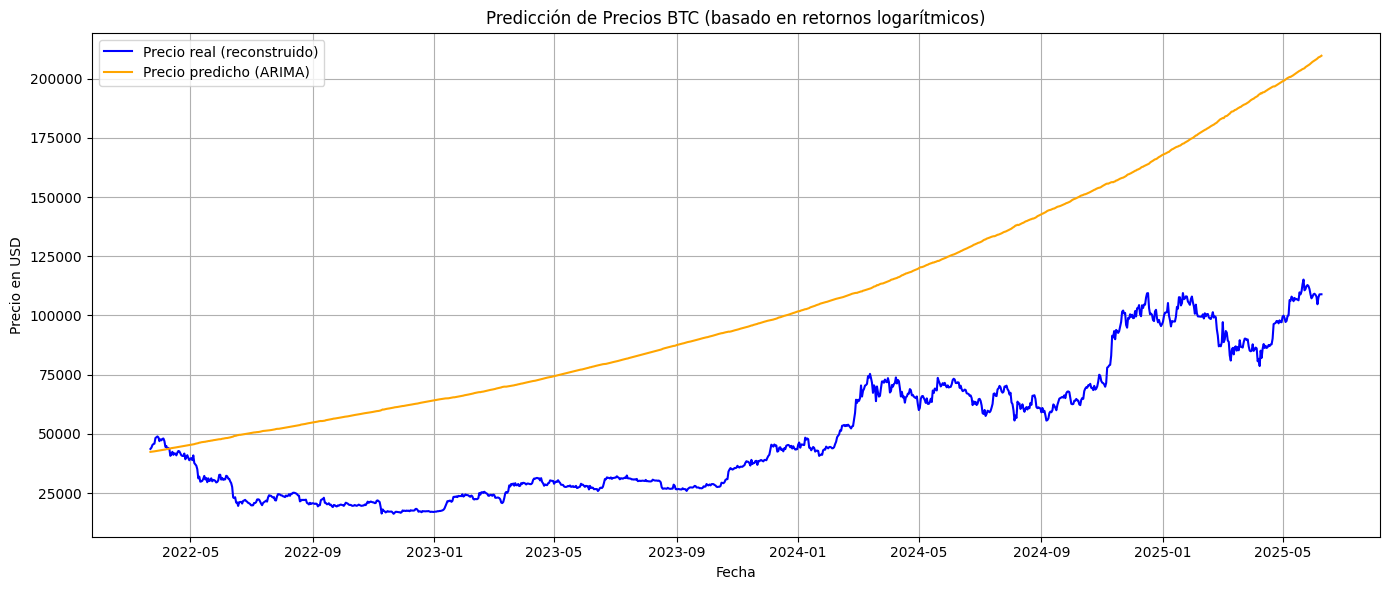

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Precio real inicial del período de test
P0 = df.loc[test.index[0], 'btc_close']

# 2. Acumular retornos log predichos y reales
log_returns_pred = pd.Series(predictions, index=test.index)
log_returns_real = test

# 3. Reconstruir precios predichos y reales
price_pred = P0 * np.exp(log_returns_pred.cumsum())
price_real = P0 * np.exp(log_returns_real.cumsum())

# 4. Graficar comparación
plt.figure(figsize=(14, 6))
plt.plot(price_real.index, price_real, label='Precio real (reconstruido)', color='blue')
plt.plot(price_pred.index, price_pred, label='Precio predicho (ARIMA)', color='orange')
plt.title('Predicción de Precios BTC (basado en retornos logarítmicos)')
plt.xlabel('Fecha')
plt.ylabel('Precio en USD')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
